<a href="https://colab.research.google.com/github/mrlocastellani/pamap2/blob/main/pamap2_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
list_of_files = [r"/content/drive/MyDrive/ColabData/Protocol/subject101.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject102.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject103.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject104.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject105.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject106.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject107.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject108.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject109.dat"]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)

54

In [14]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabData/Protocol/subject101.dat'

In [ ]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns according to the readme
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points

        return dataCollection

In [ ]:
dataCol = dataCleaning(dataCollection)
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

In [ ]:
for i in range(0, 4):
    dataCol.loc[:3, "heartrate"] = 100

In [ ]:
dataCol.to_csv('pamap_data_collection.csv', index=False)

In [13]:
dataCol

NameError: name 'dataCol' is not defined

In [ ]:
dataCol.to_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv', index=False)

In [ ]:
dataCol.head()

In [15]:
dataCollection = pd.read_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv')
print(dataCollection)

         timestamp  activityID  heartrate  handTemperature  handAcc16_1  \
0            37.66           1      100.0           30.375      2.21530   
1            37.67           1      100.0           30.375      2.29196   
2            37.68           1      100.0           30.375      2.29090   
3            37.69           1      100.0           30.375      2.21800   
4            37.70           1      100.0           30.375      2.30106   
...            ...         ...        ...              ...          ...   
1942867      95.06          24      162.0           25.125      4.99466   
1942868      95.07          24      162.0           25.125      5.02764   
1942869      95.08          24      162.0           25.125      5.06409   
1942870      95.09          24      162.0           25.125      5.13914   
1942871      95.10          24      162.0           25.125      5.00812   

         handAcc16_2  handAcc16_3  handAcc6_1  handAcc6_2  handAcc6_3  ...  \
0            8.27915 

In [16]:
dataCollection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942872 entries, 0 to 1942871
Data columns (total 43 columns):
 #   Column            Dtype  
---  ------            -----  
 0   timestamp         float64
 1   activityID        int64  
 2   heartrate         float64
 3   handTemperature   float64
 4   handAcc16_1       float64
 5   handAcc16_2       float64
 6   handAcc16_3       float64
 7   handAcc6_1        float64
 8   handAcc6_2        float64
 9   handAcc6_3        float64
 10  handGyro1         float64
 11  handGyro2         float64
 12  handGyro3         float64
 13  handMagne1        float64
 14  handMagne2        float64
 15  handMagne3        float64
 16  chestTemperature  float64
 17  chestAcc16_1      float64
 18  chestAcc16_2      float64
 19  chestAcc16_3      float64
 20  chestAcc6_1       float64
 21  chestAcc6_2       float64
 22  chestAcc6_3       float64
 23  chestGyro1        float64
 24  chestGyro2        float64
 25  chestGyro3        float64
 26  chestMagne1   

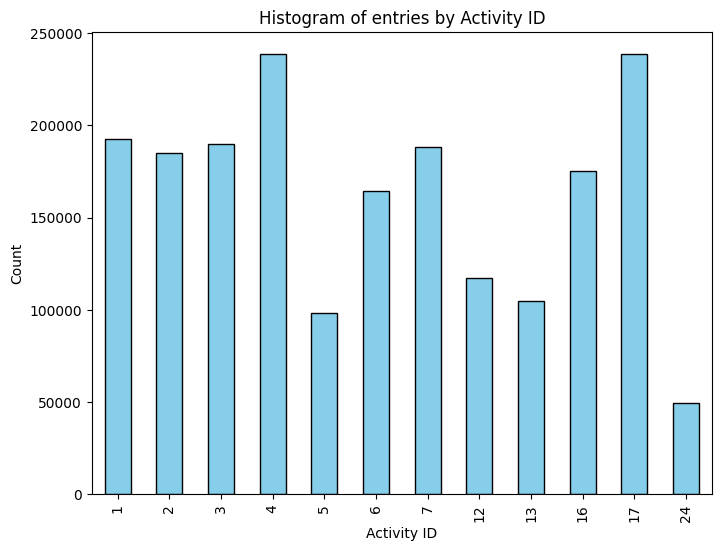

In [17]:
plt.figure(figsize=(8, 6))
dataCollection['activityID'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Histogram of entries by Activity ID')
plt.xlabel('Activity ID')
plt.ylabel('Count')
plt.show()

In [18]:
dataCollection

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,95.06,24,162.0,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,9.41274,-2.26922,-1.759580,0.021288,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,9
1942868,95.07,24,162.0,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,9.33733,-2.23908,-1.834950,0.010715,0.003629,-0.004235,-46.0331,-0.817288,0.538134,9
1942869,95.08,24,162.0,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,9.32243,-2.23905,-1.804610,-0.016939,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,9
1942870,95.09,24,162.0,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,9.38220,-2.26938,-1.880500,-0.028069,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,9


In [19]:
valid_activity_ids = [1, 2, 3, 4, 16, 17]

data = dataCollection[dataCollection['activityID'].isin(valid_activity_ids)].copy()

label_encoder = LabelEncoder()

data['activityID'] = label_encoder.fit_transform(data['activityID'])

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

CÓDIGO CORRENTE A SER TESTADO É O ABAIXO

Epoch 1/50
28275/28275 [==============================] - 260s 9ms/step - loss: 0.1729 - accuracy: 0.9464 - val_loss: 1.9438 - val_accuracy: 0.6139
Epoch 2/50
28275/28275 [==============================] - 261s 9ms/step - loss: 0.0773 - accuracy: 0.9749 - val_loss: 2.7707 - val_accuracy: 0.5986
Epoch 3/50
28275/28275 [==============================] - 250s 9ms/step - loss: 0.0603 - accuracy: 0.9801 - val_loss: 3.2843 - val_accuracy: 0.5803
Epoch 4/50
9865/9865 [==============================] - 30s 3ms/step - loss: 1.9438 - accuracy: 0.6139
Test accuracy: 0.6139


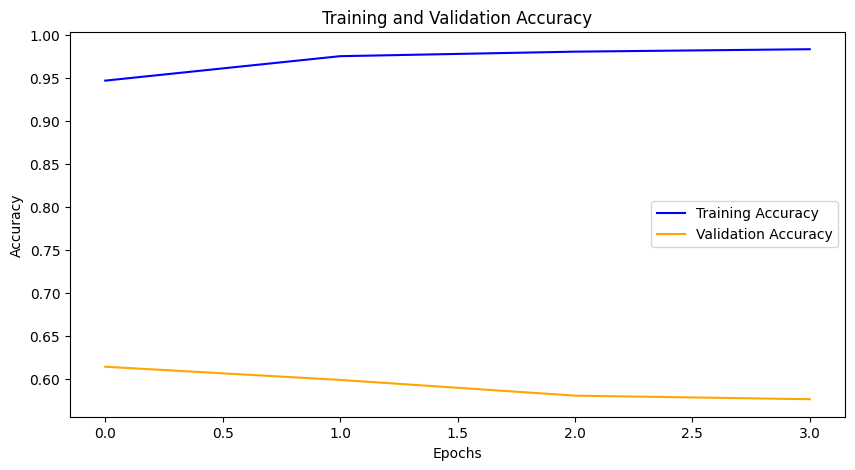

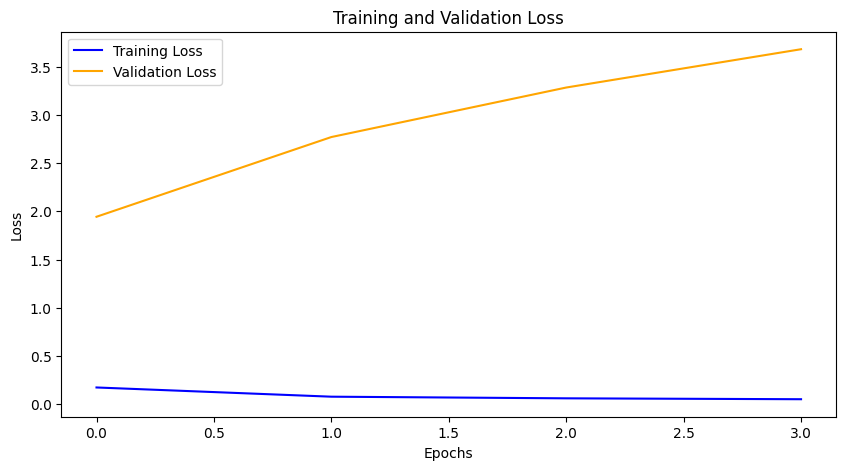

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {accuracy:.4f}')

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

num_filters = [64, 128]
filter_sizes = [3, 5, 7]
pool_sizes = [2, 3]
num_dense_neurons = [64, 128]

best_val_accuracy = 0
best_model_config = {}

for filters in num_filters:
    for size in filter_sizes:
        for pool_size in pool_sizes:
            for dense_neurons in num_dense_neurons:
                model = Sequential()
                model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
                model.add(MaxPooling1D(pool_size))
                model.add(Conv1D(filters, size, activation='relu'))
                model.add(MaxPooling1D(pool_size))
                model.add(GlobalMaxPooling1D())
                model.add(Dense(dense_neurons, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(6, activation='softmax'))

                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

                _, val_accuracy = model.evaluate(X_test, y_test_one_hot)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model_config = {
                        'filters': filters,
                        'size': size,
                        'pool_size': pool_size,
                        'dense_neurons': dense_neurons
                    }

print("Melhor configuração encontrada:", best_model_config)


Epoch 1/50
28275/28275 [==============================] - 233s 8ms/step - loss: 0.2082 - accuracy: 0.9359 - val_loss: 1.6702 - val_accuracy: 0.6208
Epoch 2/50
28275/28275 [==============================] - 235s 8ms/step - loss: 0.1010 - accuracy: 0.9678 - val_loss: 3.1213 - val_accuracy: 0.5538
Epoch 3/50
28275/28275 [==============================] - 225s 8ms/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 2.9039 - val_accuracy: 0.5658
Epoch 4/50
9865/9865 [==============================] - 28s 3ms/step - loss: 1.6702 - accuracy: 0.6208
Epoch 1/50
28275/28275 [==============================] - 208s 7ms/step - loss: 0.1664 - accuracy: 0.9469 - val_loss: 1.5440 - val_accuracy: 0.6315
Epoch 2/50
28275/28275 [==============================] - 231s 8ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 2.5524 - val_accuracy: 0.5664
Epoch 3/50
28275/28275 [==============================] - 230s 8ms/step - loss: 0.0613 - accuracy: 0.9795 - val_loss: 3.2086 - val_accuracy: 0.5526
Epoch 4/5

Epoch 1/50
22768/22768 [==============================] - 142s 6ms/step - loss: 0.0965 - accuracy: 0.9697 - val_loss: 0.0328 - val_accuracy: 0.9890
Epoch 2/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0375 - accuracy: 0.9878 - val_loss: 0.0240 - val_accuracy: 0.9918
Epoch 3/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0231 - val_accuracy: 0.9914
Epoch 4/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.0154 - val_accuracy: 0.9952
Epoch 5/50
22768/22768 [==============================] - 123s 5ms/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0160 - val_accuracy: 0.9951
Epoch 6/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0230 - accuracy: 0.9935 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 7/50
22768/22768 [==============================] - 133s 6ms/step - loss: 0.0226 - accuracy: 0.9939 - val_

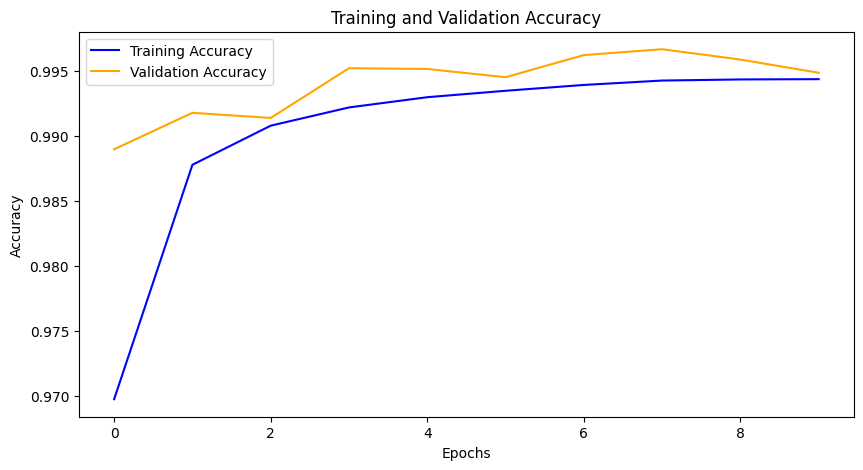

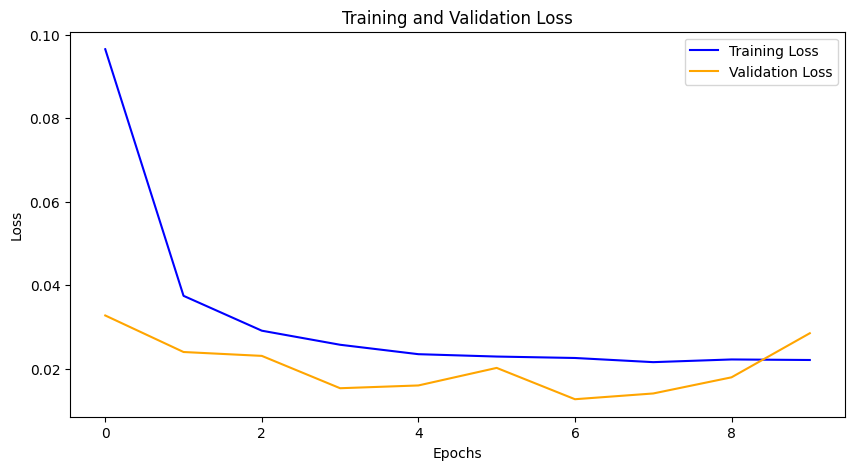

Epoch 1/50
22768/22768 [==============================] - 126s 5ms/step - loss: 0.0987 - accuracy: 0.9690 - val_loss: 0.0357 - val_accuracy: 0.9878
Epoch 2/50
22768/22768 [==============================] - 124s 5ms/step - loss: 0.0407 - accuracy: 0.9866 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 3/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0274 - val_accuracy: 0.9914
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.0122 - val_accuracy: 0.9956
Epoch 5/50
22768/22768 [==============================] - 133s 6ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0232 - val_accuracy: 0.9930
Epoch 6/50
22768/22768 [==============================] - 132s 6ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0166 - val_accuracy: 0.9953
Epoch 7/50
22768/22768 [==============================] - 135s 6ms/step - loss: 0.0228 - accuracy: 0.9936 - val_

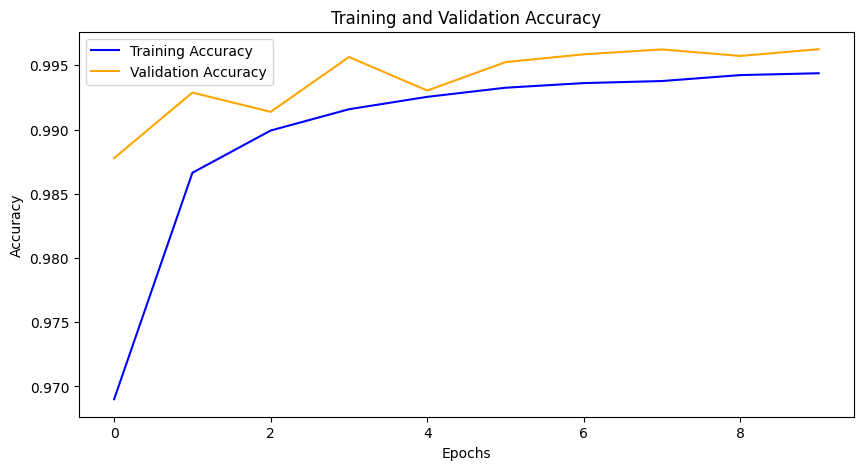

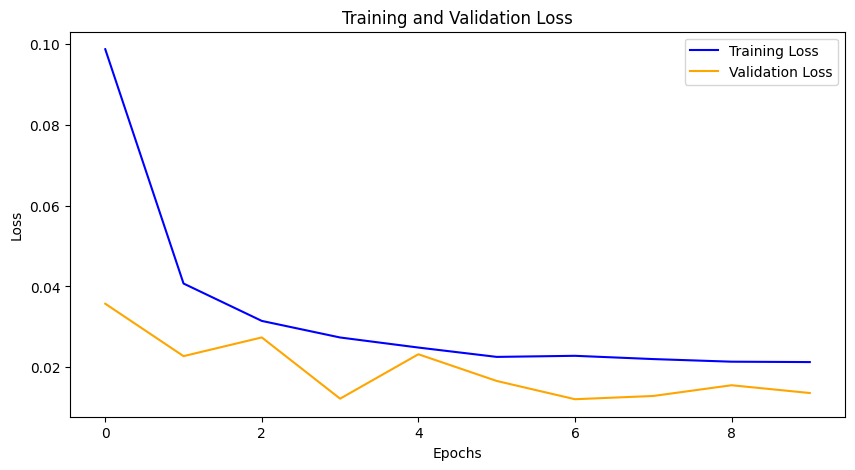

Epoch 1/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.1001 - accuracy: 0.9689 - val_loss: 0.0394 - val_accuracy: 0.9863
Epoch 2/50
22768/22768 [==============================] - 127s 6ms/step - loss: 0.0408 - accuracy: 0.9868 - val_loss: 0.0223 - val_accuracy: 0.9927
Epoch 3/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0164 - val_accuracy: 0.9945
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.0188 - val_accuracy: 0.9944
Epoch 5/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0181 - val_accuracy: 0.9937
Epoch 6/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0179 - val_accuracy: 0.9949


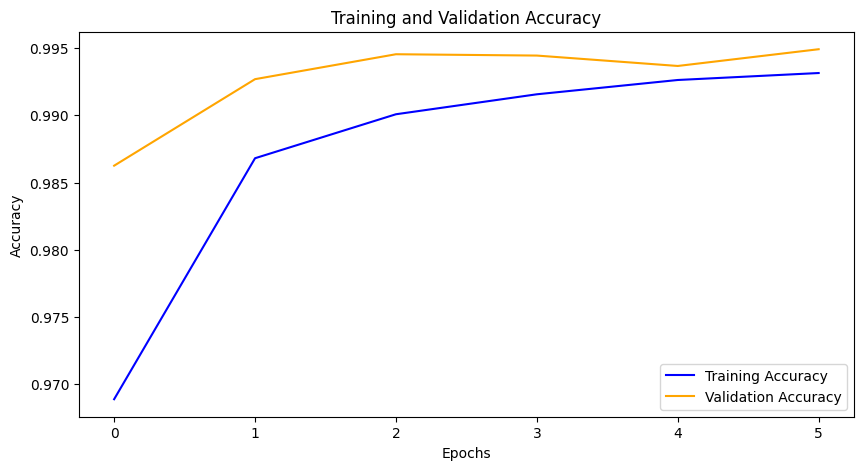

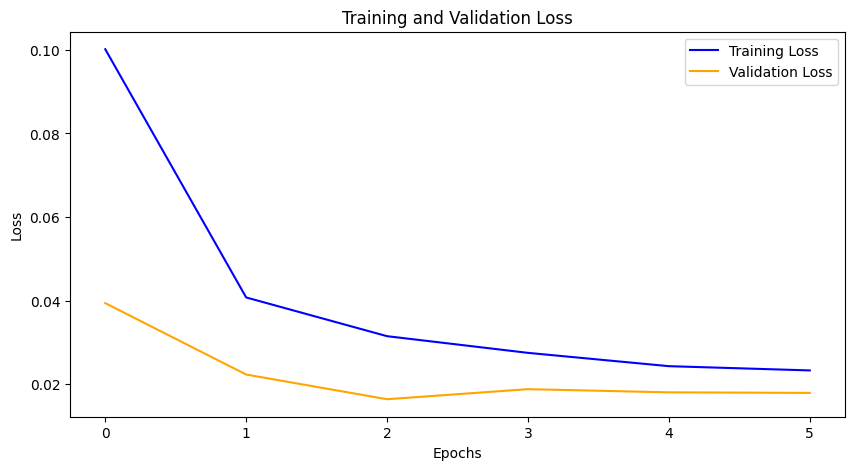

Epoch 1/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.1004 - accuracy: 0.9684 - val_loss: 0.0595 - val_accuracy: 0.9806
Epoch 2/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0425 - accuracy: 0.9861 - val_loss: 0.0257 - val_accuracy: 0.9912
Epoch 3/50
22768/22768 [==============================] - 127s 6ms/step - loss: 0.0328 - accuracy: 0.9894 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0171 - val_accuracy: 0.9940
Epoch 5/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0120 - val_accuracy: 0.9965
Epoch 6/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.0138 - val_accuracy: 0.9955
Epoch 7/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0218 - accuracy: 0.9936 - val_

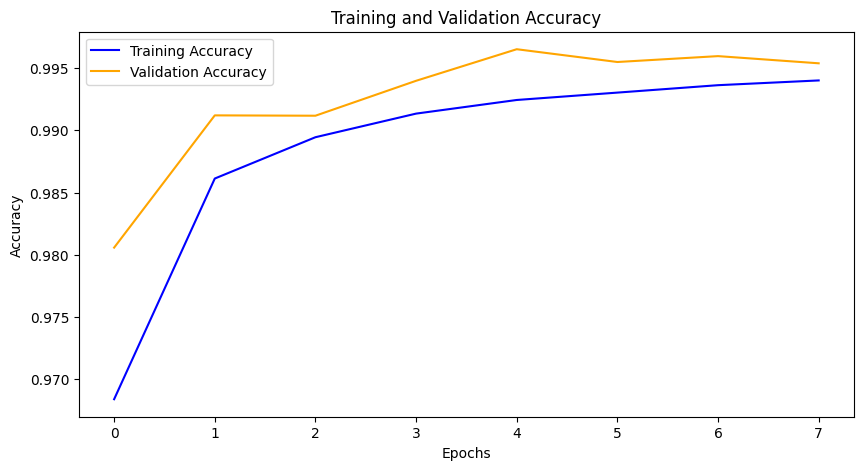

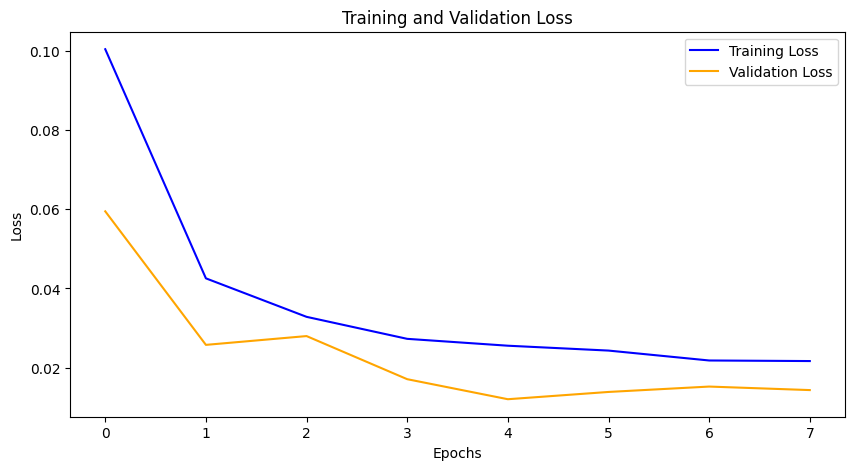

Epoch 1/50
22768/22768 [==============================] - 141s 6ms/step - loss: 0.0978 - accuracy: 0.9694 - val_loss: 0.0305 - val_accuracy: 0.9889
Epoch 2/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 3/50
22768/22768 [==============================] - 140s 6ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0182 - val_accuracy: 0.9942
Epoch 4/50
22768/22768 [==============================] - 139s 6ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0228 - val_accuracy: 0.9930
Epoch 5/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0161 - val_accuracy: 0.9950
Epoch 6/50
22768/22768 [==============================] - 147s 6ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.0191 - val_accuracy: 0.9952
Epoch 7/50
22768/22768 [==============================] - 141s 6ms/step - loss: 0.0216 - accuracy: 0.9940 - val_

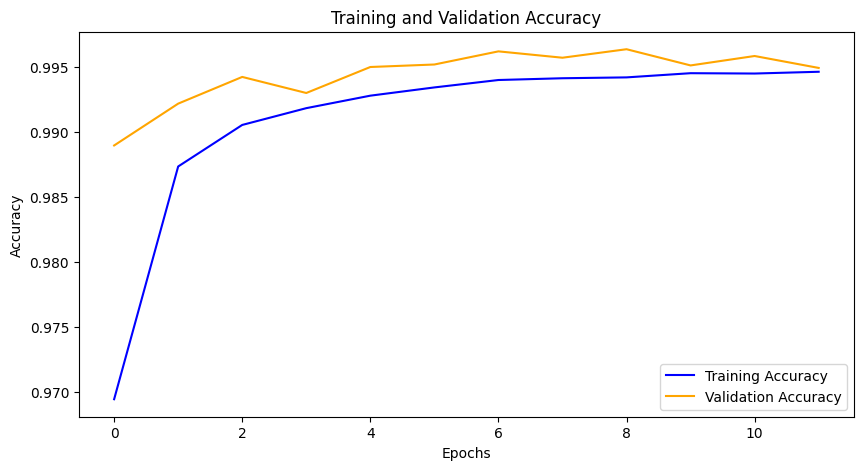

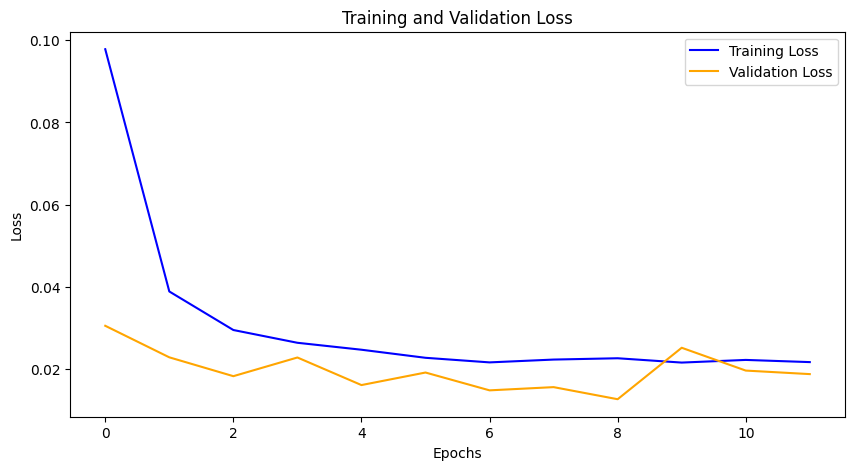

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seus dados e processamento anterior

all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

X = data_to_train[feature_columns].values
y = data_to_train[label_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

y_one_hot = to_categorical(y)

# Número de folds para o K-Fold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

# Listas para armazenar resultados de métricas
all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    filters = 128
    size = 7
    pool_size = 2
    dense_neurons = 128

    model = Sequential()
    model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size))
    model.add(Conv1D(filters, size, activation='relu'))
    model.add(MaxPooling1D(pool_size))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
model.save('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train')

NameError: name 'model' is not defined

In [5]:
data_to_test.to_csv('/content/drive/MyDrive/ColabData/data_to_test.csv', index=False)

NameError: name 'data_to_test' is not defined

In [ ]:
separate_test_data = data_to_test.copy()

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values


X_separate_test_scaled = scaler.fit_transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], X_separate_test_scaled.shape[1], 1)

separate_test_loss, separate_test_accuracy = model.evaluate(X_separate_test_scaled, to_categorical(y_separate_test))

print(f"Separate Test Set - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

9680/9680 [==============================] - 34s 3ms/step - loss: 1.8572 - accuracy: 0.8430
Separate Test Set - Loss: 1.8571697473526, Accuracy: 0.8430281281471252


9680/9680 [==============================] - 36s 4ms/step - loss: 1.8572 - accuracy: 0.8430
Separate Test Set - Loss: 1.8571697473526, Accuracy: 0.8430281281471252
9680/9680 [==============================] - 23s 2ms/step
Separate Test Set - Accuracy: 0.8430
Separate Test Set - Precision: 0.8521
Separate Test Set - Recall: 0.8430
Separate Test Set - F1: 0.8397
Separate Test Set - Cohen's Kappa: 0.8109
Separate Test Set - AUC-PR: 0.8561


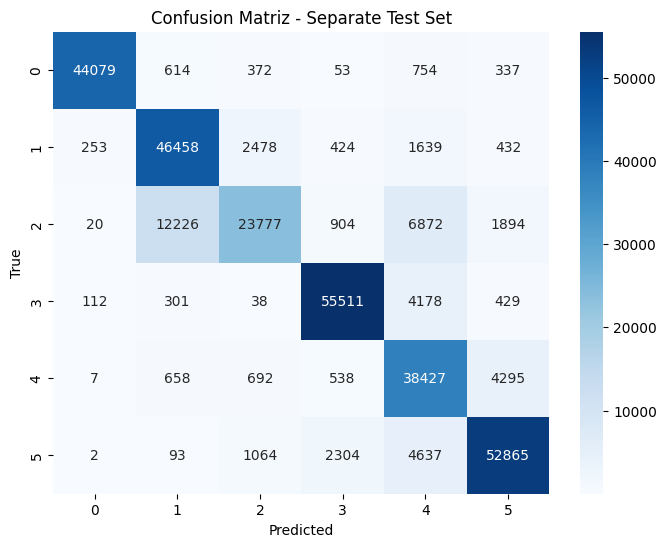

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize

# Carregar o modelo salvo
loaded_model = load_model('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train')

separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values


X_separate_test_scaled = scaler.fit_transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], X_separate_test_scaled.shape[1], 1)

separate_test_loss, separate_test_accuracy = loaded_model.evaluate(X_separate_test_scaled, to_categorical(y_separate_test))

print(f"Separate Test Set - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

y_separate_test_pred = loaded_model.predict(X_separate_test_scaled)
y_separate_test_pred_classes = np.argmax(y_separate_test_pred, axis=1)
y_separate_test_one_hot = to_categorical(y_separate_test)

# Binarizar as previsões e rótulos para multiclasse
y_separate_test_bin = label_binarize(y_separate_test, classes=np.unique(y_separate_test))
y_separate_test_pred_bin = label_binarize(y_separate_test_pred_classes, classes=np.unique(y_separate_test_pred_classes))

separate_test_accuracy = accuracy_score(y_separate_test, y_separate_test_pred_classes)
separate_test_precision = precision_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_recall = recall_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_f1 = f1_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_cohen_kappa = cohen_kappa_score(y_separate_test, y_separate_test_pred_classes)

separate_test_conf_matrix = confusion_matrix(y_separate_test, y_separate_test_pred_classes)

separate_test_precision_curve, separate_test_recall_curve, _ = precision_recall_curve(y_separate_test_bin.ravel(), y_separate_test_pred_bin.ravel())
separate_test_pr_auc = auc(separate_test_recall_curve, separate_test_precision_curve)

print(f"Separate Test Set - Accuracy: {separate_test_accuracy:.4f}")
print(f"Separate Test Set - Precision: {separate_test_precision:.4f}")
print(f"Separate Test Set - Recall: {separate_test_recall:.4f}")
print(f"Separate Test Set - F1: {separate_test_f1:.4f}")
print(f"Separate Test Set - Cohen's Kappa: {separate_test_cohen_kappa:.4f}")

print(f"Separate Test Set - AUC-PR: {separate_test_pr_auc:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(separate_test_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_separate_test), yticklabels=np.unique(y_separate_test))
plt.title('Confusion Matriz - Separate Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


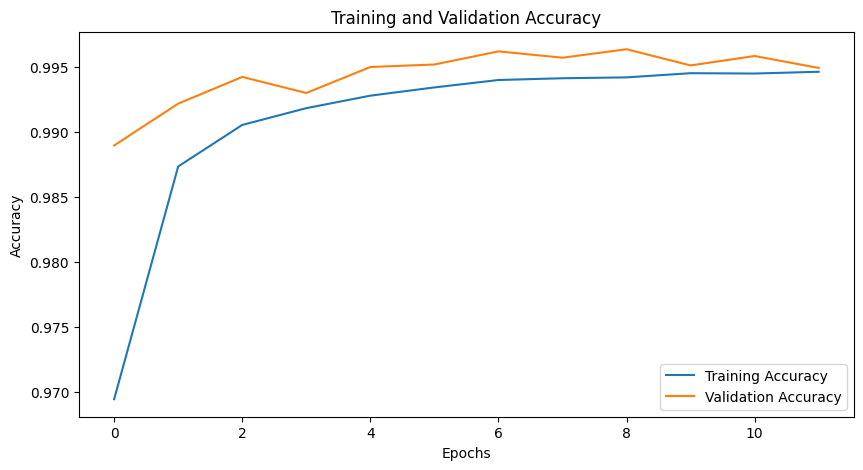

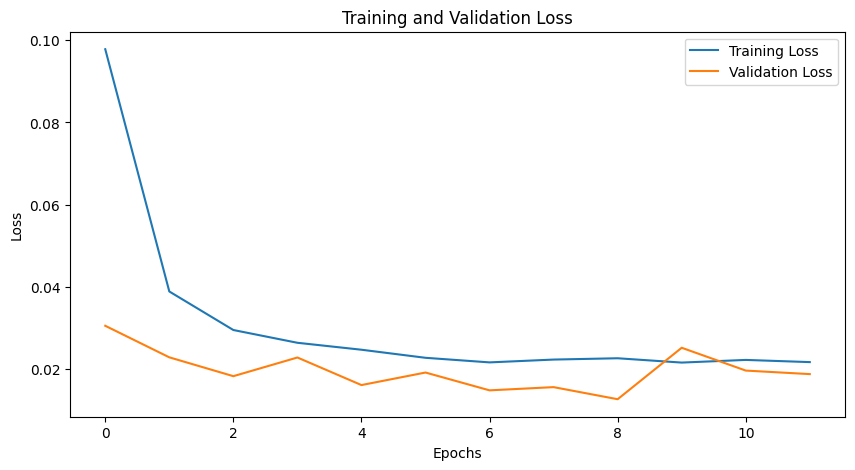

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()